uncomment if executing in google colab

In [1]:
# ! pip uninstall pyro-ppl
# ! pip install pyro-ppl==1.5.1
# ! unzip fonts.zip 
# ! unzip claptchagen.zip
# ! unzip csis
# ! cp csis.py /usr/local/lib/python3.7/dist-packages/pyro/infer

In [2]:
import random
import string
import os
import torch.nn as nn
import torch
import torch.nn.functional as F
import pyro
import numpy as np
import pyro.optim as optim
import pyro.distributions as dist
import pyro.infer
import pyro.optim

from torch.autograd import Variable
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from PIL import Image
from claptchagen.claptcha import Claptcha
from torch.distributions import constraints
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
print(pyro.__version__)

captcha_folder = 'generated_captchas'
captchaHeight = 32
captchaWidth = 100
captchaMarginX = 4
captchaMarginY = 4
batch_size = 10

#char_dict = string.ascii_lowercase
char_dict = string.digits
USE_CUDA = True
MAX_N = 5 # maximum number of letters in a captcha 
MIN_N = 3 # minimum number of letters in a captcha
MIN_NOISE = 0.01 # minimum noise
MAX_NOISE = 0.99 # maximum noise
smoke_test = False
num_steps = 200 if not smoke_test else 10
TrainingSample = 10000 if not smoke_test else 100 # number of captchas generated for training

def randomString():
    """
    return a string with <num_char> random letters
    """
    k = random.randint(MIN_N, MAX_N) # sample number of characters
    
    rndLetters = (random.choice(char_dict) for _ in range(k))
    
    pad_spaces = MAX_N - k # pad the string so the captcha is close to center
    space = " " * (pad_spaces // 2)
    
    return space + "".join(rndLetters) + space

def ramdomNoise():
    """
    return a float between MIN_NOISE, MAX_NOISE
    """
    return random.uniform(MIN_NOISE, MAX_NOISE)

def generate_random_captcha(n, save=False):
    """
    generate n random captchas,
    return a list of texts on the captchas
    """
    # Initialize Claptcha object with random text, FreeMono as font, of size
    # 100x30px, using bicubic resampling filter and adding a bit of white noise
    c = Claptcha(randomString, "fonts/FreeSans.ttf", (captchaWidth, captchaHeight), (captchaMarginX, captchaMarginY),
             resample=Image.BILINEAR, noise=0)
    captcha_generated = [ [] for i in range(MAX_N)]
    for i in range(n):
        c.noise = ramdomNoise()
        if save:
            text, _ = c.write(os.path.join(captcha_folder, 'captcha{}.png'.format(i)))
            os.rename(os.path.join(captcha_folder, 'captcha{}.png'.format(i)),os.path.join(captcha_folder, '{}.png'.format(text + "_" + str(i))))
        text, image = c.image
        text = text.strip()
        image = np.array(image)[:, :, 0] # the generator is gray scale, only keep one channel is enough
        captcha_generated[len(text) - 1].append((text, image, c.noise))
    return captcha_generated
    
captcha_generated = generate_random_captcha(TrainingSample, save=False)
for lst in captcha_generated:
    print("number of samples in group", len(lst))
    # print some sample captcha information generated
    for i, t in enumerate(lst):
        print("text", t[0], "captcha shape", t[1].shape, "noise", t[2])
        if i >= 10:
            break

1.5.1
number of samples in group 0
number of samples in group 0
number of samples in group 3397
text 086 captcha shape (32, 100) noise 0.5999366081576676
text 573 captcha shape (32, 100) noise 0.4648509584454201
text 203 captcha shape (32, 100) noise 0.12918802609607266
text 277 captcha shape (32, 100) noise 0.2065439834891904
text 264 captcha shape (32, 100) noise 0.8596382930061176
text 342 captcha shape (32, 100) noise 0.79374072433474
text 672 captcha shape (32, 100) noise 0.2232902811857313
text 560 captcha shape (32, 100) noise 0.3098095156879719
text 314 captcha shape (32, 100) noise 0.15728743032297063
text 837 captcha shape (32, 100) noise 0.9609387963172384
text 584 captcha shape (32, 100) noise 0.8630241312812751
number of samples in group 3272
text 1543 captcha shape (32, 100) noise 0.15558786849004574
text 3498 captcha shape (32, 100) noise 0.10776779103066453
text 2525 captcha shape (32, 100) noise 0.9443210319620892
text 7370 captcha shape (32, 100) noise 0.9136370370104

In [3]:
def render_image(chars, fonts="fonts/FreeSans.ttf", size=(captchaWidth, captchaHeight), 
                 margin=(captchaMarginX, captchaMarginY), resample=Image.BILINEAR, noise=0.3, use_cuda=False):
    #noise = noise.data.item()
    #print(chars, noise)
    pad_spaces = MAX_N - len(chars)
    space = " " * (pad_spaces // 2)
    chars = space + chars + space
    render = Claptcha(chars, fonts, size, margin, resample=resample, noise=noise)

    
    _ , rendered_image = render.image
    rendered_image = np.array(rendered_image)[:,:,0] # the generator is gray scale, only keep one channel is enough
    rendered_image = np.subtract(np.divide(rendered_image, 255), 0.5)
    rendered_image = torch.from_numpy(rendered_image)
    if use_cuda:
        rendered_image = rendered_image.cuda()
    return rendered_image

In [4]:
class CaptchaDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, raw_captchas, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.raw_captchas = raw_captchas
        self.transform = transform

    def __len__(self):
        return len(self.raw_captchas)

    def __getitem__(self, idx):
        label = self.raw_captchas[idx][0]
        image = self.raw_captchas[idx][1]
        noise = self.raw_captchas[idx][2]
        
        image = np.subtract(np.divide(image, 255), 0.5)
        image = torch.from_numpy(image).float()

        if self.transform:
            image = self.transform(image)

        return label, image, noise

In [5]:
def make_loarders(BATCH_SIZE, raw_samples):
    dataloaders = [] # dataloaders for different num of char
    for lst in raw_samples:
        if lst:
            ds = CaptchaDataset(lst)
            dataloader = DataLoader(ds, batch_size=BATCH_SIZE,
                                    shuffle=True, num_workers=0, drop_last=True)
            dataloaders.append(dataloader)
    return dataloaders

def make_batches(dataloaders):
    all_batches = []
    for dl in dataloaders:
        for i_batch, sample in enumerate(dl):
            all_batches.append(sample)
    random.shuffle(all_batches)
    random.shuffle(all_batches)
    return all_batches

TrainLoaders = make_loarders(BATCH_SIZE=batch_size, raw_samples=captcha_generated)

In [6]:
class NoiseNet(nn.Module):

    def __init__(self, img_size, out_size = 1):
        """
        Network for learning noise in a captcha
        """
        super(NoiseNet, self).__init__()
        
        self.img_size = img_size
        self.fc0 = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
        self.fc1 = nn.Linear(img_size[0] * img_size[1], 1024)

        self.fc21 = nn.Linear(1024, out_size)
        self.fc22 = nn.Linear(1024, out_size)
        self.softplus = nn.Softplus()
    
    def forward(self, img):
        img = img.reshape(-1, self.img_size[0] * self.img_size[1])
        hidden = F.relu(self.fc0(img))
        hidden = self.fc1(hidden)
        # mean of noise, used in normal distribution
        mean =  torch.tanh(self.fc21(F.relu(hidden)))
        # std used in normal distribution
        sigma = self.softplus(self.fc22(F.relu(hidden)))
        return mean, sigma

In [7]:
class NumNet(nn.Module):
    def __init__(self, img_size, out_size = 3):
        """
        Network for learning N, number of letters in a captcha
        """
        super(NumNet, self).__init__()
        self.neural_net = nn.Sequential(
            nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1] * 2),
            nn.ReLU(),
            nn.Linear(img_size[0] * img_size[1] * 2, 256),
            nn.ReLU(),
            nn.Linear(256, out_size),
            nn.LogSoftmax(dim=1))
  
    def forward(self, img):
        img = torch.reshape(img, (img.shape[0], img.shape[1] * img.shape[2]))
        prob = self.neural_net(img)
        return prob

In [8]:
class CharNetSingle(nn.Module):
    def __init__(self, img_size, output_size, hidden_size=512, N_num_class=10, input_size=1024, num_layers=1):
        """
        Network for letters in a captcha, given the noise and number of letters
        """
        super(CharNetSingle, self).__init__()
        self.img_size = img_size
        self.N_num_class = N_num_class
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=0.2)
        
        # output proposal layers
        self.linear_layers = nn.ModuleList([nn.Linear(hidden_size, output_size) for i in range(N_num_class)])

        #self.dropout = nn.Dropout()
        
        # observe layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.pfc1 = nn.Linear(8832, 2048)
        self.pfc2 = nn.Linear(2048, 1024)
        self.convBN1 = nn.BatchNorm2d(32)
        self.convBN2 = nn.BatchNorm2d(64)
        self.h_0 = nn.Parameter(torch.zeros(self.num_layers, 1, self.hidden_size))
        self.c_0 = nn.Parameter(torch.zeros(self.num_layers, 1, self.hidden_size)) # define if use LSTM

    def forward(self, img, N, noise_batched):
        BATCH_SIZE = img.shape[0]
        i = torch.arange(0, int(N))
        if USE_CUDA:
            i = i.cuda()
        i_onehot = F.one_hot(i, num_classes=self.N_num_class).float() # one hot format of N and index of letter
        i_onehot = torch.reshape(i_onehot, (N, 1, self.N_num_class)).repeat(1, BATCH_SIZE, 1)
        N_onehot = F.one_hot(N-1, num_classes=self.N_num_class).repeat(N, BATCH_SIZE, 1).float()
        
        # observe layers
        img = torch.reshape(img, (BATCH_SIZE, 1, self.img_size[0], self.img_size[1]))

        img = self.pool(F.relu(self.convBN1(self.conv1(img))))
        img = self.pool(F.relu(self.convBN2(self.conv2(img))))
        
        img = torch.reshape(img, (BATCH_SIZE, 8832))

        img = F.relu(self.pfc1(img))
        
        img = F.relu(self.pfc2(img))
        
        img = torch.reshape(img, (1, BATCH_SIZE, 1024))
        
        img = img.repeat(N, 1, 1)
        
        # cat observed images, N, i and noise 
        noise_batched = noise_batched.repeat(N, 1, 1)

        x = torch.cat((img, N_onehot, i_onehot, noise_batched), dim=2)
        x = torch.reshape(x, (N, BATCH_SIZE, self.input_size))

        h_0_contig = self.h_0.expand(self.num_layers, BATCH_SIZE, self.hidden_size).contiguous()
        c_0_contig = self.c_0.expand(self.num_layers, BATCH_SIZE, self.hidden_size).contiguous()

        outputs, hn = self.rnn(x, (h_0_contig,c_0_contig))
        
        # probosal layer, map to output shape
        outputs = torch.stack([self.linear_layers[i](outputs[i]) for i in range(outputs.shape[0])])

        outputs = F.log_softmax(outputs, dim=2)
        
        # transpose to <Batch, Length of Sequence, Character Space>
        outputs = torch.transpose(outputs, 0, 1)
        
        return outputs

In [9]:
def inference(t, use_cuda=False):
    """
    one epoch of inference (iterate the training set once)
    """
    loss = 0
    length = TrainingSample
    loss_group = []
    all_batches = make_batches(TrainLoaders)
    for i_batch, sample_batched in enumerate(all_batches):
        
        img = sample_batched[1]
        if use_cuda:
            img = img.cuda()
        IMG = {"captcha" : img}
        imme_loss = csis.step(observations=IMG)
        loss += imme_loss / length

    print("loss at epoch {} is {}".format(t, loss))
    return loss

In [10]:
def test(n = 0, use_train=False, verbose=False, use_cuda=False):
    """
    benchmarking performance on customized or training set
    """
    if use_train:
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=captcha_generated)
    else:
        test_captcha_generated = generate_random_captcha(n, save=False)
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=test_captcha_generated)
    
    total_correct = 0
    char_correct = 0
    total_char = 0
    all_batches = make_batches(TestLoaders)
    for i_batch, t in enumerate(all_batches):

        label = t[0][0]
        gt_noise = t[2][0]
        img = t[1]

        if use_cuda:
            img = img.cuda()
        
        IMG = {"captcha" : img}
        
        posterior = csis.run(observations=IMG)
        marginal_num = pyro.infer.EmpiricalMarginal(posterior, "num_char")
        marginal_noise = pyro.infer.EmpiricalMarginal(posterior, "noise")
        marginal_char = pyro.infer.EmpiricalMarginal(posterior, "chars")
        with torch.no_grad():

            N_index = marginal_num()
            noise = captchaModel._map_to_noise_range(marginal_noise()[0])
            char_indices = marginal_char()[0]
        
        N = N_index + captchaModel.num_char_domain[0]

        if use_cuda:
            char_indices.cpu()
        chars = ""
        for i in range(len(char_indices)):
            c = char_indices[i]
            chars +=  captchaModel.char_dict[c]
        correct = 0
        
        for p_char, t_char in zip(chars, label):
            if p_char == t_char:
                correct += 1
        if not verbose:
            print("N_predicted:", int(N), "| Actual N:", len(label), "| Predicted Noise:", round(float(noise), 3), "| Actual Noise:", round(float(gt_noise), 3), "| Predicted Text:", chars, "| Actual Text:", label, "| Correct:", correct)
        if correct == len(label) and int(N) == len(label):
            total_correct += 1
        char_correct += correct
        total_char += len(label)
    num_test_samples = i_batch + 1
    accuracy = total_correct / num_test_samples
    char_accuracy = char_correct / total_char
    print("use_train =", use_train, "Total correct:", total_correct, "accuracy:{}/{}=".format(total_correct, num_test_samples), accuracy, "char_accuracy:{}/{}=".format(char_correct, total_char), char_accuracy)


In [11]:
def test_cycle(use_cuda):
    
    # disable dropout
    #captchaModel.numNet.eval()
    #captchaModel.charNetSingle.eval()
    test(use_train=True, verbose=True, use_cuda=use_cuda)
    test(1000, use_train=False, verbose=True, use_cuda=use_cuda)
    #test(10, use_train=True, verbose=False, use_cuda=use_cuda)
    test(10, use_train=False, verbose=False, use_cuda=use_cuda)
    # enable dropout
    #captchaModel.numNet.train()
    #captchaModel.charNetSingle.train()

def optimize(use_cuda=False):
    """
    Training/Inferencing Stage
    """
    loss_sequence = []
    pause = 5
    print("Optimizing...")
    for t in range(1, num_steps + 1):
        L = inference(t, use_cuda)
        loss_sequence.append(L)
        if (t % pause == 0) and (t > 0):
            test_cycle(use_cuda=use_cuda)
    plt.plot(loss_sequence)
    plt.title("loss")
    plt.show()

Optimizing...
loss at epoch 1 is 7.785831675195704
loss at epoch 2 is 5.897452612233167
loss at epoch 3 is 4.8584093019723795
loss at epoch 4 is 4.120668009912971
loss at epoch 5 is 3.5162965051293336
use_train = True Total correct: 451 accuracy:451/10000= 0.0451 char_accuracy:17155/39934= 0.4295838132919317
use_train = False Total correct: 52 accuracy:52/1000= 0.052 char_accuracy:1726/4012= 0.43020937188434694
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.684 | Actual Noise: 0.676 | Predicted Text: 372 | Actual Text: 247 | Correct: 0
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.408 | Actual Noise: 0.396 | Predicted Text: 596 | Actual Text: 598 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.211 | Actual Noise: 0.319 | Predicted Text: 298 | Actual Text: 298 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.486 | Actual Noise: 0.942 | Predicted Text: 5537 | Actual Text: 5232 | Correct: 2
N_predicted: 5 | Actual N: 5 | Predicted Noise: 0.753 | Actual 

loss at epoch 26 is 0.9662619154482828
loss at epoch 27 is 0.9953827173260832
loss at epoch 28 is 0.9047302737511362
loss at epoch 29 is 0.8881846326905624
loss at epoch 30 is 0.8347184129135412
use_train = True Total correct: 2891 accuracy:2891/10000= 0.2891 char_accuracy:29055/39934= 0.7275754995742976
use_train = False Total correct: 282 accuracy:282/1000= 0.282 char_accuracy:2917/4039= 0.7222084674424363
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.315 | Actual Noise: 0.105 | Predicted Text: 916 | Actual Text: 816 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.566 | Actual Noise: 0.63 | Predicted Text: 906 | Actual Text: 056 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.301 | Actual Noise: 0.228 | Predicted Text: 072 | Actual Text: 972 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.333 | Actual Noise: 0.302 | Predicted Text: 6572 | Actual Text: 5572 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.248 | Actual Nois

loss at epoch 51 is 0.26797420209090644
loss at epoch 52 is 0.2590243628355806
loss at epoch 53 is 0.22424386595433682
loss at epoch 54 is 0.22666706778137033
loss at epoch 55 is 0.20521267653187442
use_train = True Total correct: 3962 accuracy:3962/10000= 0.3962 char_accuracy:31487/39934= 0.7884759853758702
use_train = False Total correct: 404 accuracy:404/1000= 0.404 char_accuracy:3159/3993= 0.7911344853493614
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.541 | Actual Noise: 0.54 | Predicted Text: 9614 | Actual Text: 9514 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.911 | Actual Noise: 0.94 | Predicted Text: 5521 | Actual Text: 5521 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.468 | Actual Noise: 0.467 | Predicted Text: 6423 | Actual Text: 5423 | Correct: 3
N_predicted: 5 | Actual N: 5 | Predicted Noise: 0.467 | Actual Noise: 0.502 | Predicted Text: 79797 | Actual Text: 79707 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.883 | 

loss at epoch 76 is -0.09645042358024672
loss at epoch 77 is -0.12692171234674307
loss at epoch 78 is -0.15408127578027192
loss at epoch 79 is -0.16527359199527608
loss at epoch 80 is -0.19964948747673772
use_train = True Total correct: 4816 accuracy:4816/10000= 0.4816 char_accuracy:32999/39934= 0.8263384584564532
use_train = False Total correct: 492 accuracy:492/1000= 0.492 char_accuracy:3318/3993= 0.830954169797145
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.272 | Actual Noise: 0.919 | Predicted Text: 340 | Actual Text: 340 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.333 | Actual Noise: 0.309 | Predicted Text: 7376 | Actual Text: 7376 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.893 | Actual Noise: 0.842 | Predicted Text: 7072 | Actual Text: 7072 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.624 | Actual Noise: 0.627 | Predicted Text: 1146 | Actual Text: 1146 | Correct: 4
N_predicted: 5 | Actual N: 5 | Predicted Noise: 0.433

loss at epoch 101 is -0.4367680415761628
loss at epoch 102 is -0.45660261536517205
loss at epoch 103 is -0.4395784954631527
loss at epoch 104 is -0.45324229484002004
loss at epoch 105 is -0.4601574302938581
use_train = True Total correct: 5615 accuracy:5615/10000= 0.5615 char_accuracy:34465/39934= 0.8630490309009866
use_train = False Total correct: 602 accuracy:602/1000= 0.602 char_accuracy:3476/3973= 0.8749056128869872
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.592 | Actual Noise: 0.591 | Predicted Text: 3617 | Actual Text: 3617 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.669 | Actual Noise: 0.682 | Predicted Text: 859 | Actual Text: 859 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.863 | Actual Noise: 0.854 | Predicted Text: 2432 | Actual Text: 2862 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.321 | Actual Noise: 0.336 | Predicted Text: 2315 | Actual Text: 2315 | Correct: 4
N_predicted: 5 | Actual N: 5 | Predicted Noise: 0.

loss at epoch 126 is -0.5443513417477619
loss at epoch 127 is -0.5490202798018986
loss at epoch 128 is -0.5545837134497569
loss at epoch 129 is -0.559554514569841
loss at epoch 130 is -0.5533047640406501
use_train = True Total correct: 5943 accuracy:5943/10000= 0.5943 char_accuracy:34966/39934= 0.875594731306656
use_train = False Total correct: 618 accuracy:618/1000= 0.618 char_accuracy:3570/4028= 0.8862959285004965
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.615 | Actual Noise: 0.608 | Predicted Text: 367 | Actual Text: 367 | Correct: 3
N_predicted: 5 | Actual N: 5 | Predicted Noise: 0.299 | Actual Noise: 0.243 | Predicted Text: 58111 | Actual Text: 58114 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.684 | Actual Noise: 0.703 | Predicted Text: 9199 | Actual Text: 0199 | Correct: 3
N_predicted: 5 | Actual N: 5 | Predicted Noise: 0.262 | Actual Noise: 0.267 | Predicted Text: 08335 | Actual Text: 08335 | Correct: 5
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.

loss at epoch 151 is -0.7170542392584449
loss at epoch 152 is -0.7344564918768128
loss at epoch 153 is -0.7289692814482235
loss at epoch 154 is -0.7395899730974793
loss at epoch 155 is -0.7500766887160999
use_train = True Total correct: 6668 accuracy:6668/10000= 0.6668 char_accuracy:36022/39934= 0.9020383632994441
use_train = False Total correct: 673 accuracy:673/1000= 0.673 char_accuracy:3661/4052= 0.9035044422507403
N_predicted: 5 | Actual N: 5 | Predicted Noise: 0.262 | Actual Noise: 0.062 | Predicted Text: 69448 | Actual Text: 69445 | Correct: 4
N_predicted: 5 | Actual N: 5 | Predicted Noise: 0.272 | Actual Noise: 0.197 | Predicted Text: 43050 | Actual Text: 43059 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.387 | Actual Noise: 0.397 | Predicted Text: 3156 | Actual Text: 3156 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.234 | Actual Noise: 0.16 | Predicted Text: 4081 | Actual Text: 4081 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise:

loss at epoch 176 is -0.7897112147483676
loss at epoch 177 is -0.7956135938525256
loss at epoch 178 is -0.7905040702947701
loss at epoch 179 is -0.7971227933842336
loss at epoch 180 is -0.7863068473207646
use_train = True Total correct: 6822 accuracy:6822/10000= 0.6822 char_accuracy:36230/39934= 0.9072469574798417
use_train = False Total correct: 705 accuracy:705/1000= 0.705 char_accuracy:3630/3966= 0.9152798789712556
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.621 | Actual Noise: 0.596 | Predicted Text: 0868 | Actual Text: 0868 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.333 | Actual Noise: 0.346 | Predicted Text: 146 | Actual Text: 246 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.332 | Actual Noise: 0.311 | Predicted Text: 873 | Actual Text: 873 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.714 | Actual Noise: 0.723 | Predicted Text: 4851 | Actual Text: 4851 | Correct: 4
N_predicted: 5 | Actual N: 5 | Predicted Noise: 0.308 

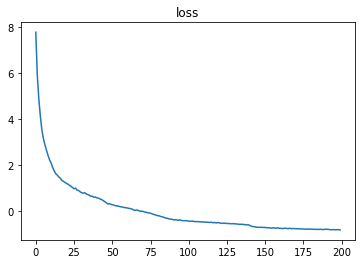

use_train = True Total correct: 7020 accuracy:7020/10000= 0.702 char_accuracy:36494/39934= 0.9138578654780387
use_train = False Total correct: 698 accuracy:698/1000= 0.698 char_accuracy:3658/4010= 0.9122194513715711
N_predicted: 5 | Actual N: 5 | Predicted Noise: 0.275 | Actual Noise: 0.122 | Predicted Text: 31580 | Actual Text: 31580 | Correct: 5
N_predicted: 5 | Actual N: 5 | Predicted Noise: 0.978 | Actual Noise: 0.976 | Predicted Text: 29919 | Actual Text: 29919 | Correct: 5
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.318 | Actual Noise: 0.331 | Predicted Text: 931 | Actual Text: 931 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.84 | Actual Noise: 0.806 | Predicted Text: 9788 | Actual Text: 9748 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.286 | Actual Noise: 0.259 | Predicted Text: 3672 | Actual Text: 3672 | Correct: 4
N_predicted: 5 | Actual N: 5 | Predicted Noise: 0.213 | Actual Noise: 0.022 | Predicted Text: 17575 | Actual Text: 13576 | 

In [12]:

class CaptchaModel(nn.Module):
    """
    network, model and guide wrapper class
    """
    def __init__(self, use_cuda=False):
        super().__init__()
        self.num_char_domain = torch.arange(MIN_N, MAX_N + 1)
        if use_cuda:
            self.num_char_domain = self.num_char_domain.cuda()

        self.numNet = NumNet((captchaHeight, captchaWidth), len(self.num_char_domain))
        self.noiseNet = NoiseNet((captchaHeight, captchaWidth), 1)
        self.char_dict = char_dict # letter dictionary
        self.rnn_hidden_size = 512
        self.rnn_num_layer = 2
        self.charNetSingle = CharNetSingle((captchaHeight, captchaWidth), len(self.char_dict), N_num_class=max(self.num_char_domain), input_size=1024 + max(self.num_char_domain) * 2 + 1, hidden_size=self.rnn_hidden_size, num_layers=self.rnn_num_layer)
        self.noise_constraint = torch.distributions.constraints.interval(MIN_NOISE, MAX_NOISE)
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
    
    def _map_to_noise_range(self, input):
        """
        map input number to the valid noise range
        """
        input = torch.distributions.transform_to(self.noise_constraint)(input)
        return input

    def guide(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        pyro.module("guide", self)
        img = observations["captcha"].float()
        
        # posterior to the number of letters
        prob = self.numNet(img)
        prob = torch.mean(prob, dim=0)
        N_index = pyro.sample("num_char", dist.Categorical(prob))
        N_index = torch.add(N_index, self.num_char_domain[0])
        
        with pyro.plate("data", img.shape[0]):
            
            # posterior to the noise
            noise_mean, noise_sig = self.noiseNet(img)
            noise_batch = pyro.sample("noise", dist.Normal(noise_mean, noise_sig).to_event(1))
            noise_batch = self._map_to_noise_range(noise_batch)
            
            # posterior to the characters, given number of letters and noise
            charP = self.charNetSingle(img, N_index, noise_batch)
            pyro.sample("chars", dist.Categorical(charP).to_event(1))
    
    def model(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        
        BS = observations["captcha"].shape[0]
        
        num_p = torch.tensor(1 / len(self.num_char_domain)).repeat(len(self.num_char_domain))
        
        if self.use_cuda:
            num_p = num_p.cuda()
        
        # sample the number of characters
        N_index = pyro.sample("num_char", dist.Categorical(num_p))
        N_index = torch.add(N_index,  self.num_char_domain[0])
        
        with pyro.plate("data", BS):
            
            noise_mean = torch.tensor((MAX_NOISE - MIN_NOISE) / 2).repeat((BS, 1))
            noise_sig = torch.tensor(0.5).repeat((BS, 1))

            if self.use_cuda:
                noise_mean = noise_mean.cuda()
                noise_sig = noise_sig.cuda()

            # sample the noise
            noise_batch = pyro.sample("noise", dist.Normal(noise_mean, noise_sig).to_event(1))
            noise_batch = self._map_to_noise_range(noise_batch)

            num_c = torch.tensor(1 / len(self.char_dict)).repeat((BS, N_index, len(self.char_dict)))
            if self.use_cuda:
                    num_c = num_c.cuda()
                    
            # sample the character indices
            c = pyro.sample("chars", dist.Categorical(num_c).to_event(1)) # maybe 2 here
            rendered_images = []
            for i in range(c.shape[0]):
                chars = ""
                for j in range(N_index):
                    chars += self.char_dict[c[i][j]]
        
                rendered_image = render_image(chars, noise=float(noise_batch[i]), use_cuda=self.use_cuda)
                rendered_images.append(rendered_image)
                
        rendered_images = torch.stack(rendered_images)
        sigma = torch.tensor(0.000001)
        if self.use_cuda:
                sigma = sigma.cuda()

        pyro.sample("captcha", dist.Normal(rendered_images, sigma).to_event(2), obs=observations["captcha"])

captchaModel = CaptchaModel(USE_CUDA)

optimiser = pyro.optim.Adam({'lr': 5e-5})
csis = pyro.infer.CSIS(captchaModel.model, captchaModel.guide, optimiser, num_inference_samples=1)


optimize(USE_CUDA)
test_cycle(USE_CUDA)